<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/scratch_cnn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/normal/IM-0435-0001-0001.jpeg  
  inflating: train/normal/IM-0435-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0002.jpeg  
  inflating: train/normal/IM-0437-0001.jpeg  
  inflating: train/normal/IM-0438-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0002.jpeg  
  inflating: train/normal/IM-0439-0001.jpeg  
  inflating: train/normal/IM-0440-0001.jpeg  
  inflating: train/normal/IM-0441-0001.jpeg  
  inflating: train/normal/IM-0442-0001.jpeg  
  inflating: train/normal/IM-0444-0001.jpeg  
  inflating: train/normal/IM-0445-0001.jpeg  
  inflating: train/normal/IM-0446-0001.jpeg  
  inflating: train/normal/IM-0447-0001.jpeg  
  inflating: train/normal/IM-0448-0001.jpeg  
  inflating: train/normal/IM-0449-0001.jpeg  
  inflating: train/normal/IM-0450-0001.jpeg  
  inflating: train/normal/IM-0451-0001.jpeg  
  in

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/val'

In [5]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [8]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

In [10]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [12]:
cnn.fit(train,epochs=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/20
262/262 [==============================] - 117s 418ms/step - loss: 0.6229 - accuracy: 0.5935 - val_loss: 0.2428 - val_accuracy: 0.9019
Epoch 2/20
262/262 [==============================] - 110s 418ms/step - loss: 0.2704 - accuracy: 0.8906 - val_loss: 0.3050 - val_accuracy: 0.8558
Epoch 3/20
262/262 [==============================] - 110s 419ms/step - loss: 0.2482 - accuracy: 0.9004 - val_loss: 0.2023 - val_accuracy: 0.9115
Epoch 4/20
262/262 [==============================] - 110s 419ms/step - loss: 0.1797 - accuracy: 0.9221 - val_loss: 0.1729 - val_accuracy: 0.9365
Epoch 5/20
262/262 [==============================] - 110s 419ms/step - loss: 0.2020 - accuracy: 0.9214 - val_loss: 0.1797 - val_accuracy: 0.9365
Epoch 6/20
262/262 [==============================] - 110s 418ms/step - loss: 0.1720 - accuracy: 0.9276 - val_loss: 0.1741 - val_accuracy: 0.9394

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/20
262/262 [=======================

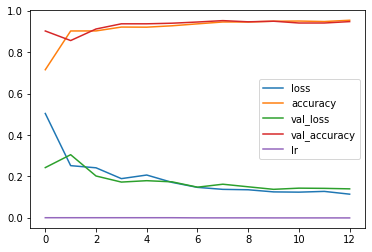

In [13]:
pd.DataFrame(cnn.history.history).plot()

In [14]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 5s 128ms/step


In [15]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

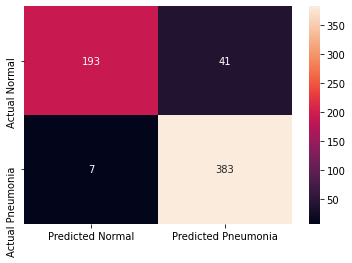

In [16]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [17]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.89       234
   PNEUMONIA       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.92       624
weighted avg       0.93      0.92      0.92       624

